In [20]:
import pandas as pd
import numpy as np
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score ,f1_score,roc_curve
import matplotlib.pyplot as plt

In [21]:
%load_ext autoreload
%autoreload 2
from data_prep import df_prep  
from data_prep import  NLP_Vectorizer
from model_src import NLP_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
col_names = ['marketplace','customer_id','review_id','product_id','product_parent','product_title','product_category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date']
cols = {}
for i in range(len(col_names)):
    print (str(i)+': '+col_names[i])
    cols[col_names[i]] = i

0: marketplace
1: customer_id
2: review_id
3: product_id
4: product_parent
5: product_title
6: product_category
7: star_rating
8: helpful_votes
9: total_votes
10: vine
11: verified_purchase
12: review_headline
13: review_body
14: review_date


In [23]:
np.random.seed(500)
df = pd.read_csv('data/sample_02.csv')
#df = df[df['7']==1]
df = df[df['9']>10]

df = df.sample(frac=.5, random_state=1)
len(df)

9616

In [24]:
Corpus = df_prep(df,.4,.0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [25]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus[['text_final','help_score','help_votes','stars']],Corpus['label'],test_size=0.3)



Train_X_Vector, Test_X_Vector, Train_Y, Test_Y = vectorize_df(Train_X['text_final'], Test_X['text_final'], Train_Y, Test_Y,'TF_IDF')





In [26]:
TF_IDF = NLP_Vectorizer('TF_IDF',{'max_features':2000,'ngram_range':(1,3)})
orig_Test_Y = Test_Y
orig_Train_Y = Train_Y
Test_Y = TF_IDF.encode_Y(Test_Y)
Train_Y = TF_IDF.encode_Y(Train_Y)

In [27]:
TF_IDF.fit(Train_X['text_final'])
Train_X_Vector = TF_IDF.transform(Train_X['text_final'])
Test_X_Vector = TF_IDF.transform(Test_X['text_final'])

In [9]:
NVB = NLP_model('RF',{'n_estimators':500})

In [10]:
NVB.fit(Train_X_Vector,Train_Y)

In [11]:
NVB_predict = NVB.predict(Test_X_Vector)

In [12]:
accuracy_score(NVB_predict,Test_Y)

0.907105719237435

In [13]:
NVB_predict

array([1, 1, 1, ..., 0, 1, 1])

In [14]:
sum(NVB_predict)/len(NVB_predict)

0.9889081455805893

In [15]:
sum(Test_Y)/len(Test_Y)

0.9057192374350087

In [16]:
Test_X['preds'] = NVB_predict
Test_X['actual'] = Test_Y

In [17]:
Test_X['correct'] = Test_X['preds'] == Test_X['actual']

In [18]:
Test_X['actual']

17676    0
21649    1
46975    1
39266    1
47775    1
        ..
50297    1
15966    1
48670    1
36277    1
14909    1
Name: actual, Length: 2885, dtype: int64

/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


(array([0.02674818, 0.02292702, 0.01528468, 0.32097822, 0.53114253,
        0.74130684, 0.72602216, 0.99350401, 1.93733282, 4.68475353]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

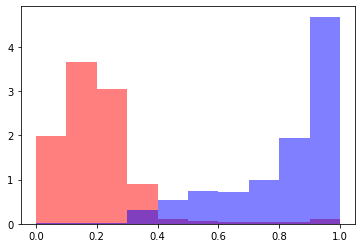

In [19]:
plt.hist(Test_X[Test_X['correct']==False]['help_score'],bins=10,normed=True,color='red',alpha=.5)
plt.hist(Test_X[Test_X['correct']==True]['help_score'],bins=10,normed=True,color='blue',alpha=.5)